In [1]:
import pickle
import os
import torch

# Directory where the cached data is stored
cache_dir = 'C:/Users/nisar/github-classroom/uwa-computer-science/project-12-prototype-bio-acoustic-detection-system-soundsentinel/dataloader_cache'

# Function to load cached data
def load_cached_data(cache_name):
    cache_path = os.path.join(cache_dir, cache_name)
    
    # Check if cache file exists
    if os.path.exists(cache_path):
        print(f"Loading cached data from {cache_path}")
        with open(cache_path, 'rb') as f:
            cached_data = pickle.load(f)
        return cached_data
    else:
        print(f"Cache file {cache_path} not found.")
        return None

# Load cached data loaders
train_loader_cache = load_cached_data('train_loader_gpu.pkl')
val_loader_cache = load_cached_data('val_loader_gpu.pkl')
test_loader_cache = load_cached_data('test_loader_gpu.pkl')

# Ensure the cached data is on the GPU if necessary
def move_data_to_gpu(cached_loader):
    gpu_loader = [(inputs.to('cuda'), targets.to('cuda')) for inputs, targets in cached_loader]
    return gpu_loader

# Move to GPU if needed (only if the data is not already on GPU)
train_loader_cache = move_data_to_gpu(train_loader_cache)
val_loader_cache = move_data_to_gpu(val_loader_cache)
test_loader_cache = move_data_to_gpu(test_loader_cache)


Loading cached data from C:/Users/nisar/github-classroom/uwa-computer-science/project-12-prototype-bio-acoustic-detection-system-soundsentinel/dataloader_cache\train_loader_gpu.pkl
Loading cached data from C:/Users/nisar/github-classroom/uwa-computer-science/project-12-prototype-bio-acoustic-detection-system-soundsentinel/dataloader_cache\val_loader_gpu.pkl
Loading cached data from C:/Users/nisar/github-classroom/uwa-computer-science/project-12-prototype-bio-acoustic-detection-system-soundsentinel/dataloader_cache\test_loader_gpu.pkl


## Esther's model

In [2]:
import torch
from torch.optim import Adam
from torch.nn import MSELoss
from rockpool.nn.networks import SynNet

# Define dataset characteristics
n_channels = 16  # Number of input channels
n_classes = 1    # the output of MSELoss is discrite
dt=10e-3          #rasterization time-step
n_time = 100    # Number of time steps 1/10e-3
batch_size = 32  # Batch size

# Initialize the SynNet model
modelesther = SynNet(
    p_dropout = 0.1,                      # Dropout proportion to use
    n_channels=16,                # Number of input channels
    n_classes=1,                  # Number of output classes 
    size_hidden_layers=[24, 24, 24],      # Number of neurons in each hidden layer
    time_constants_per_layer=[2, 4, 8],   # Time constants for each layer
    dt=10e-3,
    tau_syn_base=0.02,         # at least 2 times more than dt, how long it takes for the synaptic current to decay to a certain fraction  of its peak value.
    tau_mem=0.02,
    tau_syn_out=0.02)
print(modelesther)

ModuleNotFoundError: No module named 'torch'

In [ ]:
learning_rate = 1e-4,
epochs = 100,
batch_size = 32



In [3]:
import torch

# Function to check if a tensor is on CPU or GPU
def check_tensor_device(tensor, tensor_name="tensor"):
    print(f"{tensor_name} is on {tensor.device}")



def is_model_on_gpu(model):
    # Check if any attribute of the model has a device or is on GPU
    for param in model.parameters():
        if isinstance(param, torch.Tensor):
            return param.device.type == 'cuda'
    return False  # If no tensor found on cuda

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
if is_model_on_gpu(modelesther):
    print("model2 is on GPU.")
else:
    print("model2 is on CPU.")

model2 is on CPU.


In [6]:
def calculate_accuracy_sum_gt(model, data_loader, target_firing_rate_value=10):
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Ensure input shape matches model requirements
            outputs, _, _ = model(inputs)
            outputs = outputs.sum(dim=1)

            # Create target firing rate tensor
            target_firing_rate = torch.zeros_like(outputs).to(outputs.device)
            target_firing_rate[targets == 1] = target_firing_rate_value
            target_firing_rate[targets == 0] = 0

            # Use sigmoid activation and round predictions for binary classification
            predictions = torch.round(torch.sigmoid(outputs))

            # Compare predictions with target firing rate (binary form)
            binary_target = (target_firing_rate == target_firing_rate_value).float()

            correct += (predictions == binary_target).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy


In [7]:
def train_model(model, train_loader, optimizer, loss_fun, n_epochs=100, target_firing_rate_value=10):
    model.to(device)
    model.train()  # Set the model to training mode
    training_losses = []  # Store training loss for each epoch
    
    for epoch in range(n_epochs):
        epoch_loss = 0.0  # Initialize running loss for training
        
        # Training phase
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Clear gradients

            # Adjust input dimensions to match model expectations
            inputs = inputs.transpose(1, 2)

            # Forward pass through the network
            outputs, _, _ = model(inputs)
            outputs_sum = outputs.sum(dim=1)

            # Create target firing rate tensor
            target_firing_rate = torch.zeros_like(outputs_sum).to(outputs.device)
            target_firing_rate[targets == 1] = target_firing_rate_value
            target_firing_rate[targets == 0] = 0

            # Compute the loss using target firing rate
            loss = loss_fun(outputs_sum, target_firing_rate)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss for this batch
            epoch_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Print training loss for the current epoch
        print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss}')

    return training_losses

In [8]:
import torch

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_and_validate_model(model, train_loader, val_loader, optimizer, loss_fun, n_epochs=100, target_firing_rate_value=10):
    """
    Trains the given model for a specified number of epochs, and validates after each epoch.

    Args:
        model: The spiking neural network to train.
        train_loader: DataLoader containing training data.
        val_loader: DataLoader containing validation data.
        optimizer: Optimizer for model parameters.
        loss_fun: Loss function used for training and validation.
        n_epochs: Number of training epochs.
        target_firing_rate_value: Target firing rate for the positive class.

    Returns:
        A tuple containing:
        - A list of training losses for each epoch.
        - A list of validation losses for each epoch.
        - A list of validation accuracies for each epoch.
    """
    model.to(device)  # Move model to GPU
    training_losses = []  # Store training loss for each epoch
    validation_losses = []  # Store validation loss for each epoch
    validation_accuracies = []  # Store validation accuracy for each epoch

    for epoch in range(n_epochs):
        # Training phase
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize running loss for training
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Clear gradients

            # Move inputs and targets to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # Adjust input dimensions to match model expectations
            inputs = inputs.transpose(1, 2)

            # Forward pass through the network
            outputs, _, _ = model(inputs)
            outputs_sum = outputs.sum(dim=1)

            # Create target firing rate tensor
            target_firing_rate = torch.zeros_like(outputs_sum).to(outputs.device)
            target_firing_rate[targets == 1] = target_firing_rate_value
            target_firing_rate[targets == 0] = 0

            # Compute the loss using target firing rate
            loss = loss_fun(outputs_sum, target_firing_rate)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss for this batch
            epoch_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0  # Initialize running loss for validation
        with torch.no_grad():
            for inputs, targets in val_loader:
                # Move inputs and targets to GPU
                inputs, targets = inputs.to(device), targets.to(device)

                # Adjust input dimensions to match model expectations
                inputs = inputs.transpose(1, 2)

                # Forward pass through the network
                outputs, _, _ = model(inputs)
                outputs_sum = outputs.sum(dim=1)

                # Create target firing rate tensor
                target_firing_rate = torch.zeros_like(outputs_sum).to(outputs.device)
                target_firing_rate[targets == 1] = target_firing_rate_value
                target_firing_rate[targets == 0] = 0

                # Compute validation loss
                loss = loss_fun(outputs_sum, target_firing_rate)

                # Accumulate validation loss
                val_loss += loss.item()

        # Calculate average validation loss for the epoch
        avg_val_loss = val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)

        # Calculate validation accuracy
        val_accuracy = calculate_accuracy_sum_gt(model, val_loader, target_firing_rate_value)
        validation_accuracies.append(val_accuracy)

        # Print metrics for the current epoch
        print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

    return training_losses, validation_losses, validation_accuracies

In [9]:
def validate_model(model, val_loader, loss_fun, target_firing_rate_value=10):
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize running loss for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.transpose(1, 2)
            outputs, _, _ = model(inputs)
            outputs_sum = outputs.sum(dim=1)

            # Create target firing rate tensor for validation
            target_firing_rate = torch.zeros_like(outputs_sum).to(outputs.device)
            target_firing_rate[targets == 1] = target_firing_rate_value
            target_firing_rate[targets == 0] = 0

            # Compute validation loss
            loss = loss_fun(outputs_sum, target_firing_rate)

            # Accumulate validation loss
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy_sum_gt(model, val_loader, target_firing_rate_value)

    # Print validation metrics
    print(f'Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

    return avg_val_loss, val_accuracy

In [10]:
def test_model(model, test_loader, target_firing_rate_value=10):
    model.to(device)
    """
    Tests the model on the test set.

    Args:
        model: The spiking neural network to test.
        test_loader: DataLoader containing test data.
        target_firing_rate_value: Target firing rate for the positive class.

    Returns:
        Test accuracy.
    """
    test_accuracy = calculate_accuracy_sum_gt(model, test_loader, target_firing_rate_value)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    return test_accuracy

In [11]:
# Example usage:
n_epochs = 100
learning_rate = 0.001
optimizer = Adam(modelesther.parameters().astorch(), lr=learning_rate)
loss_fun = MSELoss()

train_losses, val_losses, val_accuracies = train_and_validate_model(
    modelesther, 
    train_loader_cache, 
    val_loader_cache, 
    optimizer, 
    loss_fun, 
    n_epochs
)

# Test the model
test_accuracy = test_model(modelesther, test_loader_cache)

Epoch 1/100, Training Loss: 60.48466981132076, Validation Loss: 62.933035714285715, Validation Accuracy: 69.71%
Epoch 2/100, Training Loss: 51.478183962264154, Validation Loss: 95.59375, Validation Accuracy: 75.96%
Epoch 3/100, Training Loss: 47.93514150943396, Validation Loss: 152.23214285714286, Validation Accuracy: 75.96%
Epoch 4/100, Training Loss: 49.737028301886795, Validation Loss: 86.0, Validation Accuracy: 76.92%
Epoch 5/100, Training Loss: 47.741745283018865, Validation Loss: 93.86160714285714, Validation Accuracy: 79.33%
Epoch 6/100, Training Loss: 45.48879716981132, Validation Loss: 133.53571428571428, Validation Accuracy: 79.81%
Epoch 7/100, Training Loss: 47.1998820754717, Validation Loss: 85.72767857142857, Validation Accuracy: 77.88%
Epoch 8/100, Training Loss: 44.768278301886795, Validation Loss: 111.38839285714286, Validation Accuracy: 78.37%
Epoch 9/100, Training Loss: 44.73997641509434, Validation Loss: 101.3125, Validation Accuracy: 81.25%
Epoch 10/100, Training Lo

## model with auc calculations

In [27]:
import torch

def calculate_auc(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    
    all_outputs = []
    all_targets = []

    # Disable gradient calculations
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Adjust input shape to match the model expectations
            outputs, _, _ = model(inputs)
            outputs = outputs.sum(dim=1)  # Sum spikes over the time dimension
            
            all_outputs.append(outputs)
            all_targets.append(targets)

    # Concatenate all batch outputs and targets
    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)

    # Sort by output scores
    sorted_indices = torch.argsort(all_outputs, descending=True)
    sorted_outputs = all_outputs[sorted_indices]
    sorted_targets = all_targets[sorted_indices]

    # Calculate TPR and FPR at various thresholds
    thresholds = torch.unique(sorted_outputs)  # Unique output scores as thresholds
    tpr = []
    fpr = []

    pos_count = (sorted_targets == 1).sum().item()  # Number of positive examples
    neg_count = (sorted_targets == 0).sum().item()  # Number of negative examples

    tp = 0  # True positives
    fp = 0  # False positives

    for threshold in thresholds:
        # For each threshold, consider predictions >= threshold as positive class (1)
        predictions = (sorted_outputs >= threshold).float()

        tp = ((predictions == 1) & (sorted_targets == 1)).sum().item()  # True positives
        fp = ((predictions == 1) & (sorted_targets == 0)).sum().item()  # False positives

        tpr.append(tp / pos_count)  # True positive rate
        fpr.append(fp / neg_count)  # False positive rate

    # Convert lists to tensors
    tpr = torch.tensor(tpr)
    fpr = torch.tensor(fpr)

    # Calculate AUC using trapezoidal rule
    auc = torch.trapz(tpr, fpr).item()  # Integrate TPR vs FPR

    return auc


In [45]:
def calculate_auc_with_curve(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    
    all_outputs = []
    all_targets = []

    # Disable gradient calculations
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Adjust input shape to match the model expectations
            outputs, _, _ = model(inputs)
            outputs = outputs.sum(dim=1)  # Sum spikes over the time dimension
            
            all_outputs.append(outputs)
            all_targets.append(targets)

    # Concatenate all batch outputs and targets
    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)

    # Sort by output scores
    sorted_indices = torch.argsort(all_outputs, descending=True)
    sorted_outputs = all_outputs[sorted_indices]
    sorted_targets = all_targets[sorted_indices]
    return all_outputs


In [40]:
# Calculate AUC on the validation set after each epoch
val_auc = calculate_auc_with_curve(modelesther, val_loader_cache)

# Log AUC to W&B
wandb.log({
    "epoch": epoch + 1,
    "train_loss": avg_train_loss,
    "val_loss": avg_val_loss,
    "val_accuracy": val_accuracy,
    "val_auc": val_auc
})

# Print AUC
print(f'Epoch {epoch + 1}/{n_epochs}, Validation AUC: {val_auc:.4f}')


NameError: name 'wandb' is not defined

In [32]:
# Checking class distribution
targets = torch.cat([targets for _, targets in val_loader_cache])
pos_count = (targets == 1).sum().item()
neg_count = (targets == 0).sum().item()

print(f"Positive samples: {pos_count}, Negative samples: {neg_count}")

Positive samples: 104, Negative samples: 104


In [46]:
# Calculate AUC on the validation set after each epoch
all_outputs = calculate_auc_with_curve(modelesther, val_loader_cache)

In [47]:
# Print model outputs to inspect their range
print(all_outputs)  # Show the first 20 sorted outputs to see the range


tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 9.],
        [ 0.],
        [ 7.],
        [ 8.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 8.],
        [ 9.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 9.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 8.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 7.],
        [ 0.],
        [ 7.],
        [ 0.],
        [ 9.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 3.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 4.],
        [ 0.],
        [ 0.],
        [ 8.],
        [ 2.],
        [ 0.],
        [ 0.],
        [ 

In [48]:
zero_output_indices = (all_outputs == 0).nonzero(as_tuple=True)[0]
print("Indices of zero outputs:", zero_output_indices)

# Optionally, print the inputs that lead to zero outputs
for idx in zero_output_indices:
    print(f"Input at index {idx} leading to zero output:", inputs[idx])

Indices of zero outputs: tensor([  0,   1,   2,   4,   7,   8,   9,  10,  11,  14,  15,  16,  18,  19,
         20,  21,  22,  23,  24,  25,  26,  28,  29,  30,  31,  32,  33,  34,
         35,  36,  37,  39,  41,  43,  44,  45,  46,  48,  49,  50,  51,  52,
         53,  54,  56,  57,  58,  60,  61,  64,  65,  66,  68,  71,  72,  73,
         74,  75,  76,  79,  81,  84,  85,  87,  88,  89,  90,  91,  92,  96,
         97,  99, 100, 101, 102, 103, 105, 106, 115, 116, 128, 143, 184, 194,
        202, 205], device='cuda:0')


NameError: name 'inputs' is not defined

In [51]:
def visualize_spike_activity(model, inputs, sample_idx, device='cuda'):
    model.eval()  # Set model to evaluation mode
    inputs = inputs.to(device)  # Send inputs to the same device as the model
    
    # Select a specific validation sample
    sample_input = inputs[sample_idx].unsqueeze(0)  # Add batch dimension if necessary

    with torch.no_grad():
        # Perform the forward pass on the selected sample to get spikes and outputs
        outputs, spikes, _ = model(sample_input.transpose(1, 2))  # Adjust for input shape

    # Return spikes for all neurons and timesteps
    return spikes.squeeze()  # Remove extra dimensions if necessary


In [52]:
def plot_spike_raster(spikes, sample_idx):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a raster plot: plot each spike (neuron_idx, time_step)
    for neuron_idx in range(spikes.shape[0]):
        spike_times = torch.nonzero(spikes[neuron_idx]).squeeze().cpu().numpy()
        ax.plot(spike_times, neuron_idx * torch.ones_like(spike_times), 'k.', markersize=2)

    ax.set_title(f"Neuron Spiking Activity for Sample {sample_idx}")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Neuron Index")
    plt.show()

In [55]:
# Assuming you have a validation set 'val_loader' and inputs are handled like in your validation function
# Get a batch of validation inputs and targets
inputs, _ = next(iter(val_loader_cache))  # Get a batch from the val_loader
inputs = inputs.to(device)  # Ensure the inputs are on the correct device (GPU or CPU)

# Choose a specific sample from the batch to visualize
sample_idx = 10  # Choose an index for visualization

# Get the spike activity for this sample
spikes = visualize_spike_activity(modelesther, inputs, sample_idx, device)

# Plot the spike raster for the selected sample
plot_spike_raster(spikes, sample_idx)


AttributeError: 'TorchModuleParameters' object has no attribute 'squeeze'

In [56]:
def forward(self, x):
    # Process the input and calculate the spikes
    spike_activity = self.compute_spikes(x)  # Assuming this computes spike activity
    output_sums = spike_activity.sum(dim=1)  # Sum spikes over time
    
    return output_sums, spike_activity  # Return both summed output and raw spikes


In [57]:
def visualize_spike_activity(model, inputs, sample_idx, device='cuda'):
    model.eval()  # Set model to evaluation mode
    inputs = inputs.to(device)  # Send inputs to the same device as the model
    
    # Select a specific validation sample
    sample_input = inputs[sample_idx].unsqueeze(0)  # Add batch dimension if necessary

    with torch.no_grad():
        # Perform the forward pass on the selected sample to get spike activity
        outputs, spikes = model(sample_input.transpose(1, 2))  # Model should return spikes and outputs

    # Return spikes for all neurons and timesteps
    return spikes  # Assuming spikes is already the correct tensor


In [58]:
outputs, spikes = modelesther(sample_input.transpose(1, 2))
print("Outputs:", outputs)
print("Spikes:", spikes)


NameError: name 'sample_input' is not defined

In [59]:
def extract_sample_from_loader(val_loader, sample_index=0):
    """
    Extract a specific sample from the validation loader.

    Args:
        val_loader: DataLoader object containing validation data.
        sample_index: Index of the sample to extract from the validation set.

    Returns:
        single_input: The input corresponding to the specified index.
        single_target: The target corresponding to the specified index.
    """
    extracted_input = None
    extracted_target = None

    # Iterate through the validation loader
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        # If the sample index is within this batch
        if sample_index < len(inputs):
            extracted_input = inputs[sample_index].unsqueeze(0)  # Add batch dimension
            extracted_target = targets[sample_index].unsqueeze(0)  # Add batch dimension
            break
        else:
            # Move to the next batch and adjust the sample index accordingly
            sample_index -= len(inputs)

    return extracted_input, extracted_target


In [60]:
def visualize_model_functioning(model, val_loader, sample_index=0, device='cuda'):
    """
    Visualize the functioning of the model for a specific sample from the validation loader.

    Args:
        model: The trained model to visualize.
        val_loader: DataLoader object containing validation data.
        sample_index: Index of the sample to visualize.
        device: Device to run the model on ('cuda' or 'cpu').

    Returns:
        None (plots the model functioning or spike activity).
    """
    # Extract the input and target for the specified sample
    single_input, single_target = extract_sample_from_loader(val_loader, sample_index)
    
    # Send the input to the device
    single_input = single_input.to(device)
    
    # Ensure the model is in evaluation mode
    model.eval()

    # Perform forward pass on the extracted input
    with torch.no_grad():
        outputs, spikes, _ = model(single_input.transpose(1, 2))  # Adjust for input shape
    
    # Visualize the spikes using the raster plot
    plot_spike_raster(spikes.squeeze(), sample_index)

    # Optionally print the model output and target
    print(f"Model Output: {outputs}")
    print(f"Target Output: {single_target}")



In [61]:
def plot_spike_raster(spikes, sample_idx):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a raster plot: plot each spike (neuron_idx, time_step)
    for neuron_idx in range(spikes.shape[0]):
        spike_times = torch.nonzero(spikes[neuron_idx]).squeeze().cpu().numpy()
        ax.plot(spike_times, neuron_idx * torch.ones_like(spike_times), 'k.', markersize=2)

    ax.set_title(f"Neuron Spiking Activity for Sample {sample_idx}")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Neuron Index")
    plt.show()


In [63]:
# Visualize the model functioning for a specific sample
visualize_model_functioning(modelesther, val_loader_cache, sample_index=10, device='cuda')


AttributeError: 'TorchModuleParameters' object has no attribute 'squeeze'

In [64]:
def visualize_model_functioning(model, val_loader, sample_index=0, device='cuda'):
    """
    Visualize the functioning of the model for a specific sample from the validation loader.
    """
    # Extract the input and target for the specified sample
    single_input, single_target = extract_sample_from_loader(val_loader, sample_index)
    
    # Send the input to the device
    single_input = single_input.to(device)
    
    # Ensure the model is in evaluation mode
    model.eval()

    # Perform forward pass on the extracted input
    with torch.no_grad():
        outputs = model(single_input.transpose(1, 2))  # Adjust for input shape
    
    # Print the outputs to understand what the model returns
    print(f"Model Output: {outputs}")

    # Return the output for inspection
    return outputs


In [65]:
# Inspect the model output for a specific sample
output = visualize_model_functioning(modelesther, val_loader_cache, sample_index=10, device='cuda')


Model Output: (tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [

In [13]:
events, label = val_loader_cache[3]

In [14]:
events

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [15]:
label

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [16]:
def visualize_model_functioning(model, events, labels, sample_index=0, device='cuda'):
    """
    Visualize the functioning of the model for a specific sample from the events tensor.

    Args:
        model: The trained model to visualize.
        events: Tensor containing spike data [batch_size, n_neurons, n_time_steps].
        labels: Tensor containing target labels for the samples.
        sample_index: Index of the sample to visualize.
        device: Device to run the model on ('cuda' or 'cpu').

    Returns:
        None (plots the model functioning or spike activity).
    """
    # Extract the input and target for the specified sample
    single_input = events[sample_index].unsqueeze(0).to(device)  # Add batch dimension and move to device
    single_target = labels[sample_index].to(device)  # Target label for this sample

    # Ensure the model is in evaluation mode
    model.eval()

    # Perform forward pass on the extracted input
    with torch.no_grad():
        outputs, spikes_dict, _ = model(single_input.transpose(1, 2))  # Adjust for input shape if needed

    # Extract spikes from various layers
    spikes_layer_1 = spikes_dict['seq']['1_LIFTorch']['spikes']
    spikes_layer_4 = spikes_dict['seq']['4_LIFTorch']['spikes']
    spikes_layer_7 = spikes_dict['seq']['7_LIFTorch']['spikes']
    spikes_layer_10 = spikes_dict['seq']['10_LIFTorch']['spikes']

    # Print the spikes for each layer (for debugging)
    print(f"Spikes Layer 1: {spikes_layer_1}")
    print(f"Spikes Layer 4: {spikes_layer_4}")
    print(f"Spikes Layer 7: {spikes_layer_7}")
    print(f"Spikes Layer 10: {spikes_layer_10}")

    # Visualize the spikes from a specific layer (you can choose any layer)
    plot_spike_raster(spikes_layer_1, sample_index)  # Example: visualizing spikes from layer 1
    print(f"Label for sample {sample_index}: {single_target.item()}")  # Print the label of the sample



In [17]:
def plot_spike_raster(spikes, sample_idx):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a raster plot: plot each spike (neuron_idx, time_step)
    for neuron_idx in range(spikes.shape[0]):
        spike_times = torch.nonzero(spikes[neuron_idx]).squeeze().cpu().numpy()
        ax.plot(spike_times, neuron_idx * np.ones_like(spike_times), 'k.', markersize=2)

    ax.set_title(f"Neuron Spiking Activity for Sample {sample_idx}")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Neuron Index")
    plt.show()


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spike_raster(events, sample_idx=0):
    """
    Plots the spike activity for a specific sample from the events tensor.

    Args:
        events: A 3D tensor containing spike data [batch_size, n_neurons, n_time_steps].
        sample_idx: Index of the sample to visualize in the batch.

    Returns:
        None
    """
    # Extract the spikes for the given sample (events[sample_idx] is of shape [n_neurons, n_time_steps])
    spikes = events[sample_idx].cpu()  # Ensure data is on CPU for plotting

    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a raster plot: plot each spike (neuron_idx, time_step)
    for neuron_idx in range(spikes.shape[0]):  # Iterate over neurons
        spike_times = torch.nonzero(spikes[neuron_idx]).squeeze().numpy()  # Get the times when this neuron spikes

        # Plot the spike times as dots
        ax.plot(spike_times, neuron_idx * np.ones_like(spike_times), 'k.', markersize=2)

    ax.set_title(f"Neuron Spiking Activity for Sample {sample_idx}")
    ax.set_xlabel("Time Steps")
    plt.show()



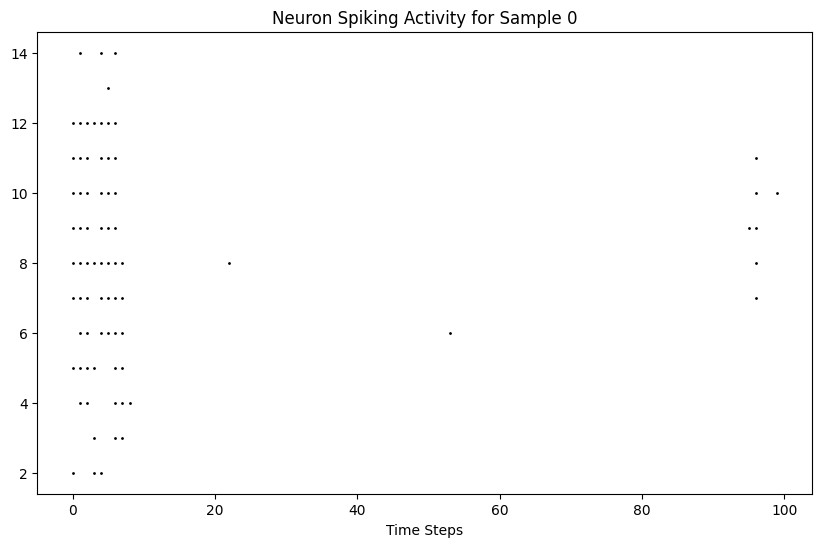

In [21]:
plot_spike_raster(events, sample_idx=0)


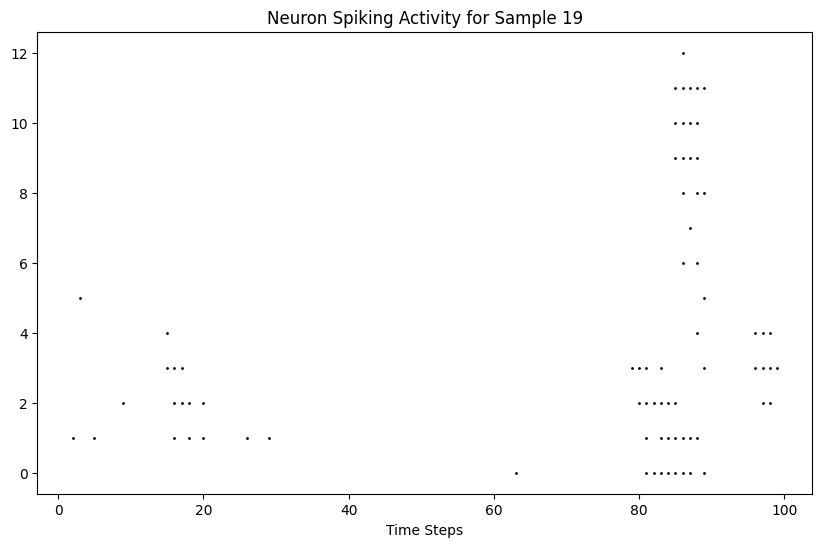

In [22]:
plot_spike_raster(events, sample_idx=19)

In [23]:
import matplotlib.pyplot as plt
import torch

def visualize_internal_activity(model, events, labels, sample_index=0, device='cuda'):
    """
    Visualize the internal neuron activities (membrane potentials, synaptic currents, spikes)
    in the hidden and output layers for a specific sample from the events tensor.

    Args:
        model: The trained SynNet model to visualize.
        events: Tensor containing spike data [batch_size, n_neurons, n_time_steps].
        labels: Tensor containing target labels for the samples.
        sample_index: Index of the sample to visualize.
        device: Device to run the model on ('cuda' or 'cpu').

    Returns:
        None (plots the internal neuron activities).
    """
    # Extract the input and target for the specified sample
    single_input = events[sample_index].unsqueeze(0).to(device)  # Add batch dimension and move to device
    single_target = labels[sample_index].to(device)  # Target label for this sample

    # Ensure the model is in evaluation mode
    model.eval()

    # Perform forward pass on the extracted input
    with torch.no_grad():
        outputs, spikes_dict, _ = model(single_input.transpose(1, 2))  # Adjust for input shape if needed

    # Extract membrane potentials, synaptic currents, and spikes from various layers
    layer_activities = spikes_dict['seq']

    # Define which layers you want to visualize
    layers_to_visualize = ['1_LIFTorch', '4_LIFTorch', '7_LIFTorch', '10_LIFTorch']

    # Plot internal neuron activities for each layer
    for layer_name in layers_to_visualize:
        vmem = layer_activities[layer_name]['vmem']  # Membrane potentials
        isyn = layer_activities[layer_name]['isyn']  # Synaptic currents
        spikes = layer_activities[layer_name]['spikes']  # Spike events

        fig, axs = plt.subplots(3, 1, figsize=(10, 8))

        # Plot membrane potentials
        axs[0].plot(vmem.cpu().numpy().T)
        axs[0].set_title(f"{layer_name} - Membrane Potentials")
        axs[0].set_xlabel("Time Steps")
        axs[0].set_ylabel("Membrane Potential")

        # Plot synaptic currents
        axs[1].plot(isyn.cpu().numpy().T)
        axs[1].set_title(f"{layer_name} - Synaptic Currents")
        axs[1].set_xlabel("Time Steps")
        axs[1].set_ylabel("Synaptic Current")

        # Plot spikes
        for neuron_idx in range(spikes.shape[0]):
            spike_times = torch.nonzero(spikes[neuron_idx]).squeeze().cpu().numpy()
            axs[2].plot(spike_times, neuron_idx * np.ones_like(spike_times), 'k.', markersize=2)
        axs[2].set_title(f"{layer_name} - Spike Activity")
        axs[2].set_xlabel("Time Steps")
        axs[2].set_ylabel("Neuron Index")

        plt.tight_layout()
        plt.show()

    print(f"Label for sample {sample_index}: {single_target.item()}")


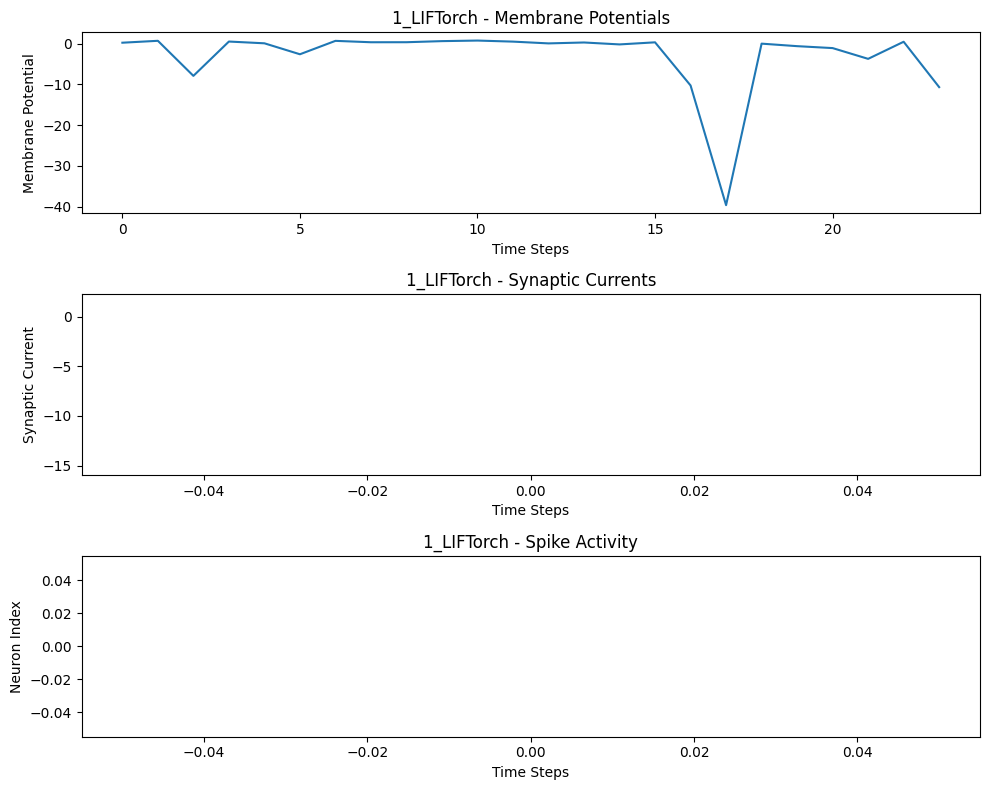

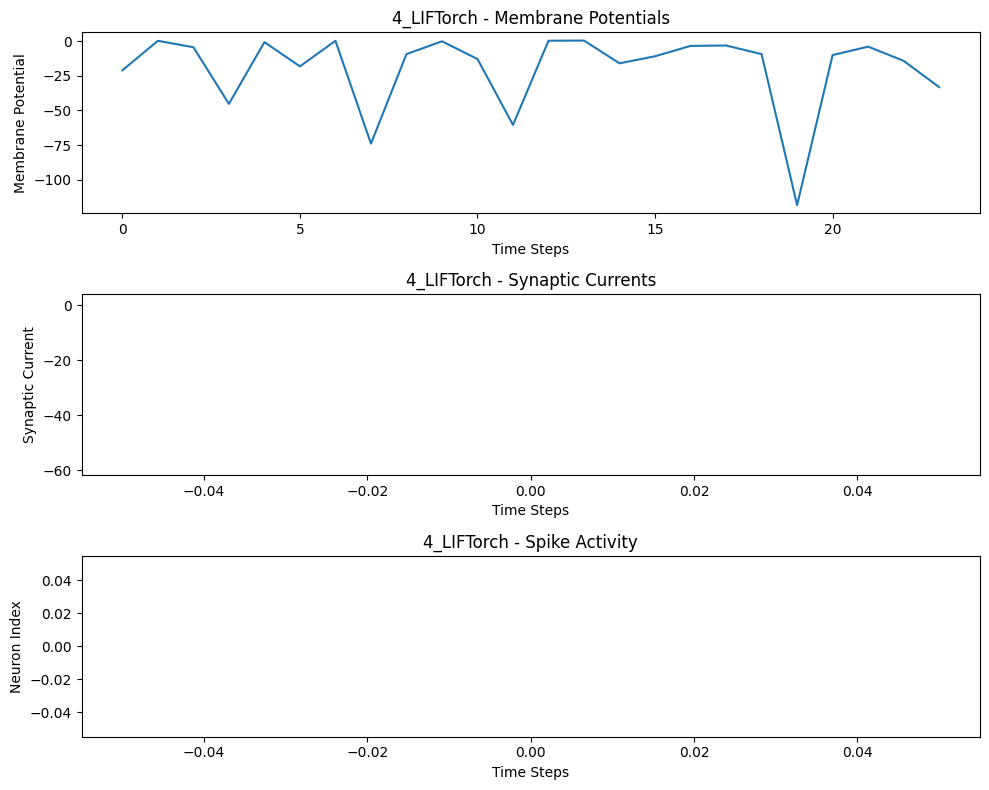

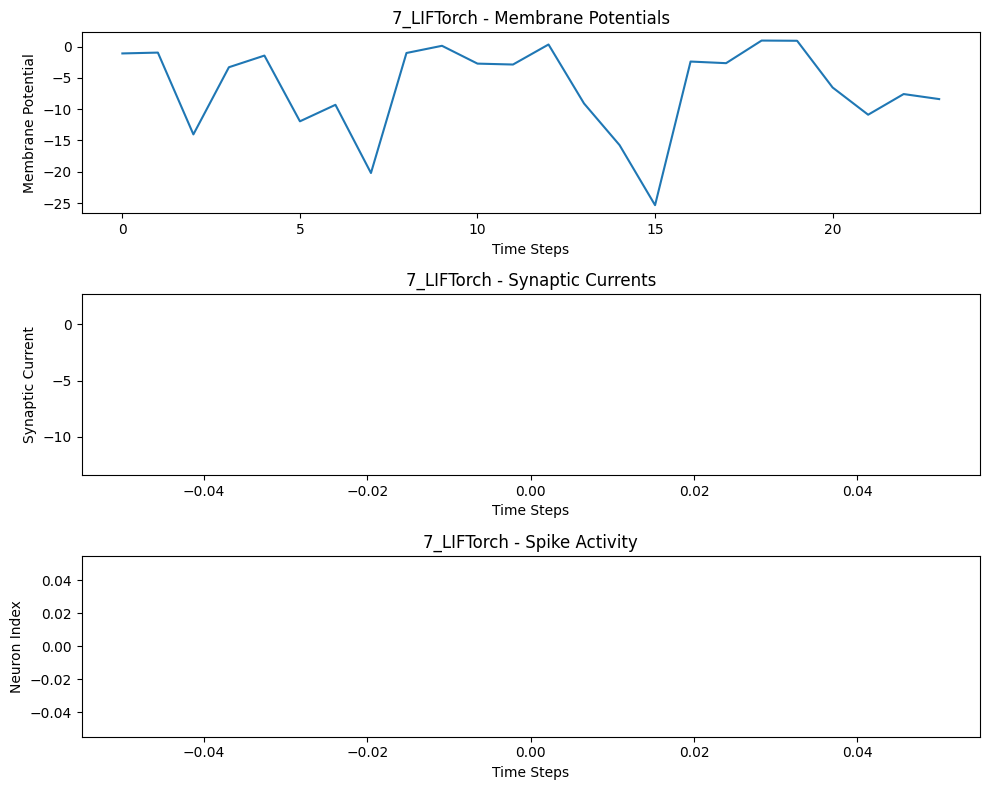

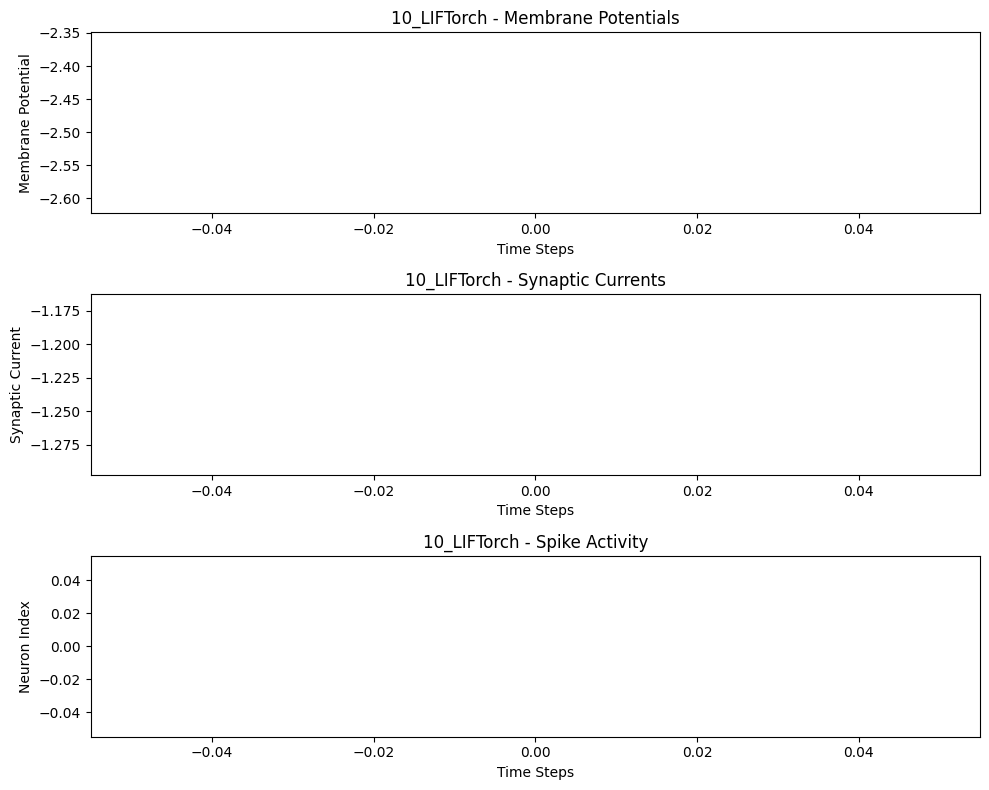

Label for sample 0: 0


In [105]:
visualize_internal_activity(modelesther, events, label, sample_index=0, device='cuda')


In [24]:
def investigate_layer_activity(model, events, labels, sample_index=0, device='cuda'):
    """
    Investigate the internal activity (membrane potential, synaptic current, spikes)
    of the neurons in the final and preceding layers.

    Args:
        model: The trained SynNet model to visualize.
        events: Tensor containing spike data [batch_size, n_neurons, n_time_steps].
        labels: Tensor containing target labels for the samples.
        sample_index: Index of the sample to visualize.
        device: Device to run the model on ('cuda' or 'cpu').

    Returns:
        None (prints the internal activity details).
    """
    # Extract the input and target for the specified sample
    single_input = events[sample_index].unsqueeze(0).to(device)  # Add batch dimension and move to device
    single_target = labels[sample_index].to(device)  # Target label for this sample

    # Ensure the model is in evaluation mode
    model.eval()

    # Perform forward pass on the extracted input
    with torch.no_grad():
        outputs, spikes_dict, _ = model(single_input.transpose(1, 2))  # Adjust for input shape if needed

    # Investigate activity for the final layer (e.g., '10_LIFTorch') and the layer before it (e.g., '7_LIFTorch')
    for layer_name in ['7_LIFTorch', '10_LIFTorch']:
        vmem = spikes_dict['seq'][layer_name]['vmem']
        isyn = spikes_dict['seq'][layer_name]['isyn']
        spikes = spikes_dict['seq'][layer_name]['spikes']

        print(f"Layer: {layer_name}")
        print(f"Membrane Potential (vmem): {vmem}")
        print(f"Synaptic Current (isyn): {isyn}")
        print(f"Spikes: {spikes}")
        print("-" * 40)


In [25]:
investigate_layer_activity(modelesther, events, label, sample_index=0, device='cuda')


Layer: 7_LIFTorch
Membrane Potential (vmem): tensor([-5.9139e-24, -2.9672e-10,  1.1631e-06, -5.1580e-01, -1.2677e-02,
        -1.6229e+01, -1.8326e+01, -6.5452e+01,  8.0206e-25, -8.5614e-11,
        -8.1787e-05, -1.5494e-01, -7.1110e+00, -1.5967e+01, -2.2520e+01,
        -2.6587e+01, -1.4090e-23, -4.6569e-10, -1.9900e-04,  1.0258e-04,
        -8.9324e+00, -2.3161e+01, -1.9256e+01, -3.9507e+01], device='cuda:0')
Synaptic Current (isyn): tensor([[-6.9500e-26],
        [-9.8908e-11],
        [ 4.9848e-07],
        [-2.4071e-01],
        [-6.1342e-03],
        [-7.9857e+00],
        [-9.0911e+00],
        [-3.2598e+01],
        [ 9.4078e-27],
        [-2.8538e-11],
        [-3.5052e-05],
        [-7.2307e-02],
        [-3.4408e+00],
        [-7.8567e+00],
        [-1.1172e+01],
        [-1.3241e+01],
        [-1.6552e-25],
        [-1.5523e-10],
        [-8.5284e-05],
        [ 4.7872e-05],
        [-4.3221e+00],
        [-1.1397e+01],
        [-9.5524e+00],
        [-1.9676e+01]], device=

In [26]:
def investigate_layer_activity(model, events, labels, sample_index=0, device='cuda'):
    single_input = events[sample_index].unsqueeze(0).to(device)  # Add batch dimension and move to device
    print(f"Input shape after unsqueeze: {single_input.shape}")  # Shape after adding batch dimension

    single_input = single_input.transpose(1, 2)
    print(f"Input shape after transpose: {single_input.shape}")  # Shape after transpose

    single_target = labels[sample_index].to(device)  # Target label for this sample

    # Ensure the model is in evaluation mode
    model.eval()

    # Perform forward pass on the extracted input
    with torch.no_grad():
        outputs, spikes_dict, _ = model(single_input)  # Adjust for input shape if needed
        print(f"Outputs shape: {outputs.shape}")  # Check output shape


In [28]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


Xylo

In [1]:
from rockpool.devices.xylo.syns61201 import mapper

spec = mapper(modelesther.as_graph(), weight_dtype="float")
print(spec["weights_in"])

ModuleNotFoundError: No module named 'rockpool'

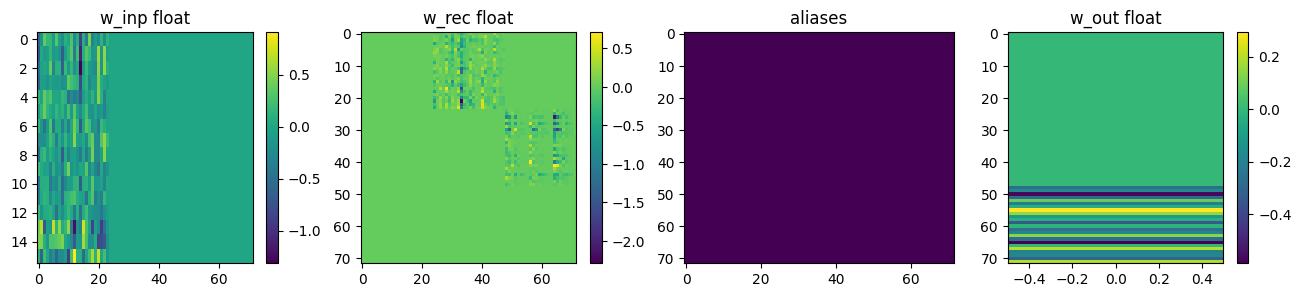

In [30]:
w_inp_float = spec["weights_in"]
w_rec_float = spec["weights_rec"]
w_out_float = spec["weights_out"]
aliases = spec["aliases"]

fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(141)
ax.set_title("w_inp float")
im = ax.imshow(w_inp_float[:, :], aspect="auto", interpolation="None")
plt.colorbar(im)

ax = fig.add_subplot(142)
ax.set_title("w_rec float")
im = ax.imshow(w_rec_float[:, :], aspect="auto", interpolation="None")
plt.colorbar(im)

ax = fig.add_subplot(143)
ax.set_title("aliases")
aliases_ = np.zeros_like(w_rec_float[:, :])
for i, a in enumerate(aliases):
    if len(a) > 0:
        aliases_[i, a[0]] = 1
im = ax.imshow(aliases_, aspect="auto", interpolation="None")

ax = fig.add_subplot(144)
ax.set_title("w_out float")
im = ax.imshow(w_out_float, aspect="auto", interpolation="None")
plt.colorbar(im);

In [ ]:
#modelesther = SynNet(
#    p_dropout = 0.1,                      # Dropout proportion to use
#    n_channels=16,                # Number of input channels
#    n_classes=1,                  # Number of output classes 
#    size_hidden_layers=[24, 24, 24],      # Number of neurons in each hidden layer
#    time_constants_per_layer=[2, 4, 8],   # Time constants for each layer
#    dt=10e-3,
#    tau_syn_base=0.02,         # at least 2 times more than dt, how long it takes for the synaptic current to decay to a certain fraction  of its peak value.
#    tau_mem=0.02,
#    tau_syn_out=0.02)
#print(modelesther)

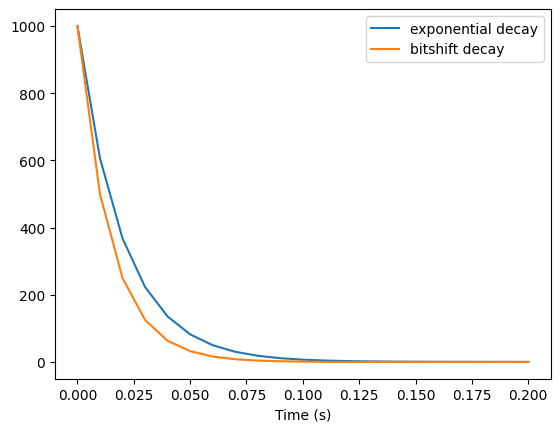

In [33]:
tau = 0.02  
dt_ = 10e-3

dash = np.round(np.log2(tau / dt_)).astype(int)
exp_propagator = np.exp(-dt_ / tau)

simtime = 0.2  # 1 sec
t_ = 0
v_tau = [1000]
v_dash = [1000]
while t_ < simtime:
    v_tau.append(v_tau[-1] * exp_propagator)
    if (v_dash[-1] >> dash) > 0:
        v_dash.append(v_dash[-1] - (v_dash[-1] >> dash))
    else:
        v_dash.append(int(np.clip(v_dash[-1] - 1, 0, np.inf)))
    t_ += dt_

plt.plot(np.arange(0, len(v_tau)) * dt_, v_tau, label="exponential decay")
plt.plot(np.arange(0, len(v_dash)) * dt_, v_dash, label="bitshift decay")
plt.legend()
plt.xlabel("Time (s)");

In [34]:
from rockpool.transform import quantize_methods as q

quant_spec = spec.copy()
del quant_spec["mapped_graph"]
del quant_spec["dt"]
quant_spec.update(q.global_quantize(**quant_spec))
print(quant_spec["weights_in"])

[[[-32]
  [ -9]
  [ 20]
  ...
  [  0]
  [  0]
  [  0]]

 [[-40]
  [  2]
  [ -7]
  ...
  [  0]
  [  0]
  [  0]]

 [[-28]
  [ -2]
  [  1]
  ...
  [  0]
  [  0]
  [  0]]

 ...

 [[ 24]
  [ 37]
  [-38]
  ...
  [  0]
  [  0]
  [  0]]

 [[ 27]
  [ 26]
  [  5]
  ...
  [  0]
  [  0]
  [  0]]

 [[  7]
  [-33]
  [ 12]
  ...
  [  0]
  [  0]
  [  0]]]


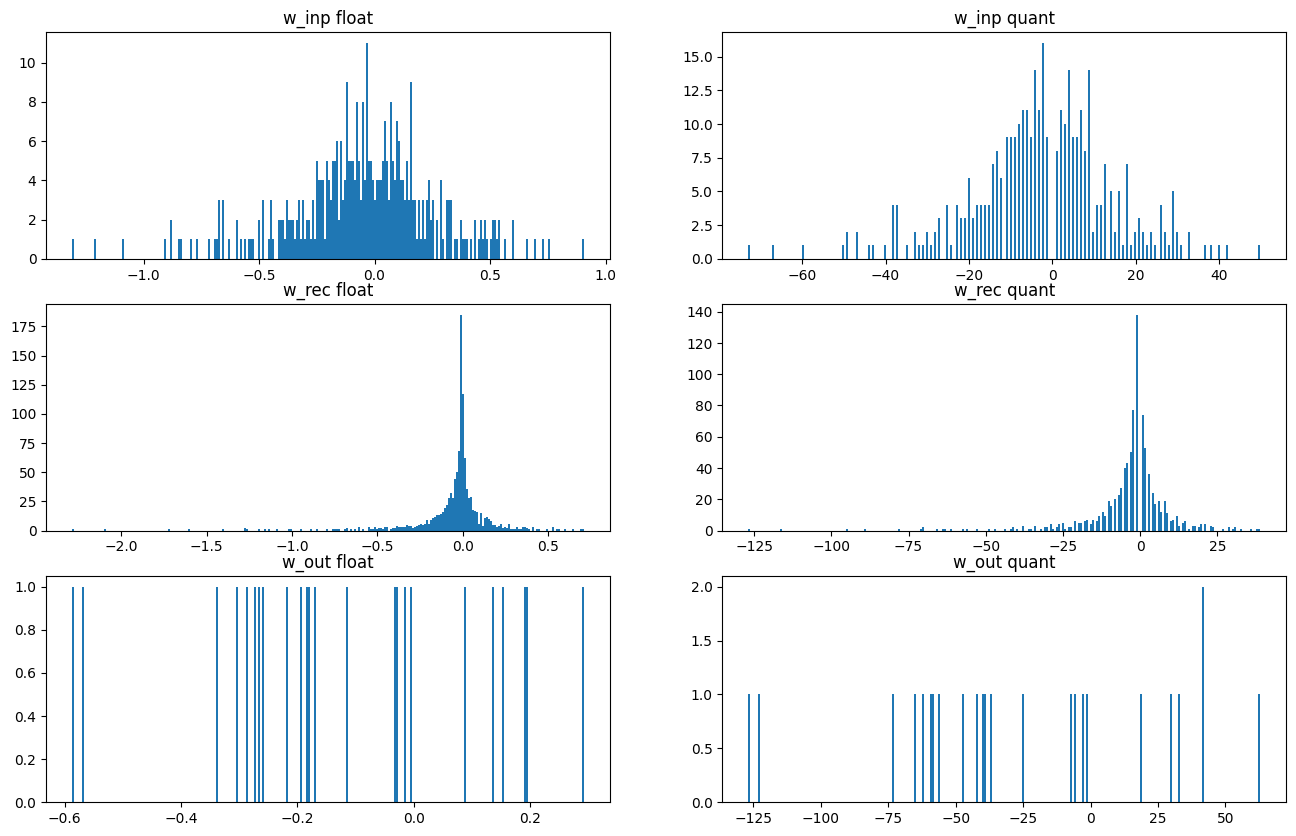

In [36]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(321)
ax.set_title("w_inp float")
ax.hist(np.ravel(w_inp_float[w_inp_float != 0]), bins=2**8)

ax = fig.add_subplot(322)
ax.set_title("w_inp quant")
ax.hist(np.ravel(quant_spec["weights_in"][quant_spec["weights_in"] != 0]), bins=2**8)

ax = fig.add_subplot(323)
ax.set_title("w_rec float")
ax.hist(np.ravel(w_rec_float[w_rec_float != 0]), bins=2**8)

ax = fig.add_subplot(324)
ax.set_title("w_rec quant")
ax.hist(
    np.ravel(quant_spec["weights_rec"][quant_spec["weights_rec"] != 0]), bins=2**8
)

ax = fig.add_subplot(325)
ax.set_title("w_out float")
ax.hist(np.ravel(w_out_float[w_out_float != 0]), bins=2**8)

ax = fig.add_subplot(326)
ax.set_title("w_out quant")
ax.hist(
    np.ravel(quant_spec["weights_out"][quant_spec["weights_out"] != 0]), bins=2**8
);

In [56]:
import samna

In [48]:
from rockpool.devices.xylo.syns61201 import config_from_specification

xylo_conf, is_valid, message = config_from_specification(**quant_spec)
print("Valid config: ", is_valid)

ModuleNotFoundError: Missing the `samna` backend. `config_from_specification` objects, and others relying on `samna` are not available.

In [42]:
from rockpool.devices.xylo.syns61201 import XyloSim
from rockpool.timeseries import TSEvent

In [52]:
sim = XyloSim.from_config(xylo_conf, dt=dt).timed(add_events=True)

ModuleNotFoundError: Missing the `xylosim, samna` backend. `XyloSim` objects, and others relying on `xylosim, samna` are not available.

In [54]:
import samna
print(samna.__version__)  # Should print 0.39.6.0


0.39.6.0
